# Chapter 14: The General Linear Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, binom, scoreatpercentile
import pingouin as pg
import matplotlib
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import localconverter
# import NHANES package
base = importr('NHANES')
%load_ext rpy2.ipython

with localconverter(ro.default_converter + pandas2ri.converter):
  NHANES = ro.conversion.rpy2py(ro.r['NHANES'])

 
NHANES = NHANES.drop_duplicates(subset='ID')
NHANES_adult = NHANES.dropna(subset=['Weight']).query('Age > 17 and BPSysAve > 0')

rng = np.random.default_rng(1234567)

## Figure 14.1

Text(0, 0.5, 'Grade (percent)')

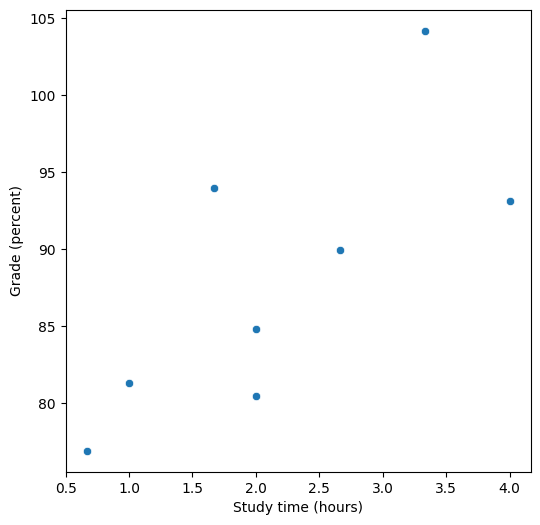

In [2]:
# Data differ from book example because y values are random samples
betas = np.array([6, 5])

df = pd.DataFrame({'studyTime': np.array([2, 3, 5, 6, 6, 8, 10, 12]) / 3,
                   'priorClass': [0, 1, 1, 0, 1, 0, 1, 0]})
grade_intercept = 70
df['grade'] = df.values.dot(betas) + rng.normal(size=8, loc = grade_intercept, scale = 5)

fig = plt.figure(figsize=(6,6))
sns.scatterplot(data=df, x='studyTime', y='grade')
plt.xlabel('Study time (hours)')
plt.ylabel('Grade (percent)')


## Correlation test

In [3]:
# compute correlation between grades and study time
corTestResult = pg.corr(df['studyTime'], df['grade'])
corTestResult

,n,r,CI95%,p-val,BF10,power
pearson,8,0.742254,"[0.08, 0.95]",0.034959,2.886,0.612544


## Figure 14.2

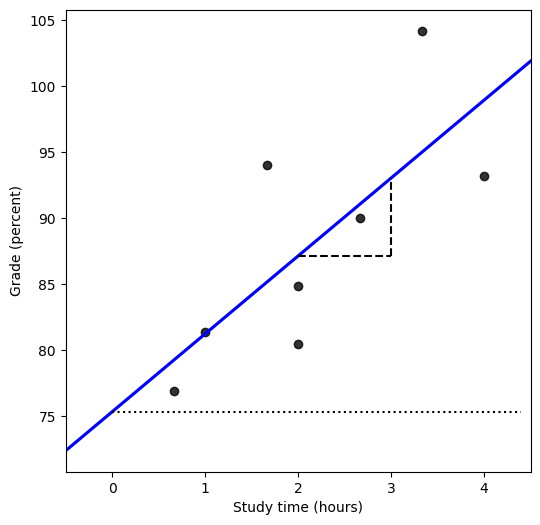

In [4]:
mod = smf.ols(formula='grade ~ studyTime', data=df)
res = mod.fit()

fig = plt.figure(figsize=(6,6))
plt.xlim([-0.5, 4.5])
sns.regplot(data=df, x='studyTime', y='grade', color='black', 
            line_kws={'color': 'blue'}, ci=None, truncate=False)
plt.xlabel('Study time (hours)')
plt.ylabel('Grade (percent)')
xmax = df.studyTime.max() * 1.1

plt.plot([2, 3], [res.params.dot(np.array([1, 2])), res.params.dot(np.array([1, 2]))], 'k', linestyle='dashed')
plt.plot([3, 3], [res.params.dot(np.array([1, 2])), res.params.dot(np.array([1, 3]))], 'k', linestyle='dashed')
plt.plot([0, xmax], [res.params['Intercept'], res.params['Intercept']], 'k:')

## Table 14.1

In [5]:
nstudents = 100

readingScores = pd.DataFrame({'test1': rng.normal(100, 10, nstudents),
                              'test2': rng.normal(100, 10, nstudents)})

cutoff = scoreatpercentile(readingScores.test1, 25)

readingScores[readingScores.test1 < cutoff].mean()

test1    87.084873
test2    99.249985
dtype: float64

## Linear model output

In [6]:
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                  grade   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     7.361
Date:                Tue, 21 Feb 2023   Prob (F-statistic):             0.0350
Time:                        06:58:30   Log-Likelihood:                -25.157
No. Observations:                   8   AIC:                             54.31
Df Residuals:                       6   BIC:                             54.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     75.3225      5.241     14.371      0.0

/home/poldrack/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## Linear regression output for study time and prior class

In [7]:
mod2 = smf.ols(formula='grade ~ studyTime + priorClass', data=df)
res2 = mod2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                  grade   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     8.889
Date:                Tue, 21 Feb 2023   Prob (F-statistic):             0.0226
Time:                        06:58:30   Log-Likelihood:                -22.294
No. Observations:                   8   AIC:                             50.59
Df Residuals:                       5   BIC:                             50.83
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     69.9340      4.655     15.024      0.0

/home/poldrack/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## Figure 14.3

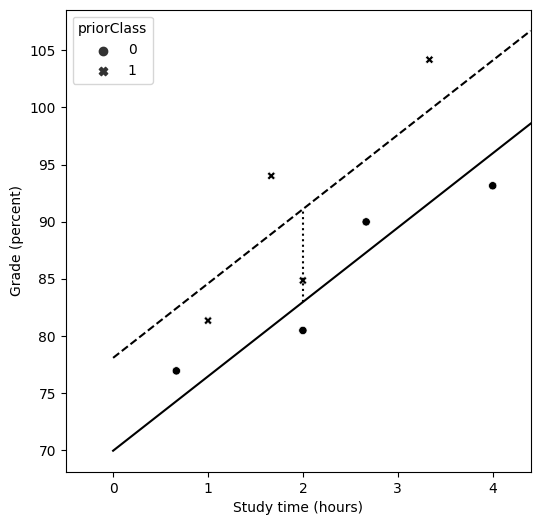

In [8]:

fig = plt.figure(figsize=(6,6))
plt.xlim([-0.5, xmax])

sns.scatterplot(data=df, x='studyTime', y='grade', color='black', style='priorClass')
plt.xlabel('Study time (hours)')
plt.ylabel('Grade (percent)')
xmax = df.studyTime.max() * 1.1

plt.plot([0, xmax], [res2.params.dot(np.array([1, 0, 0])), res2.params.dot(np.array([1, xmax, 0]))], 'k')
plt.plot([0, xmax], [res2.params.dot(np.array([1, 0, 1])), res2.params.dot(np.array([1, xmax, 1]))], 'k', linestyle='dashed')
plt.plot([2, 2], [res2.params.dot(np.array([1, 2, 0])), res2.params.dot(np.array([1, 2, 1]))], 'k', linestyle='dotted')


## Figure 14.4

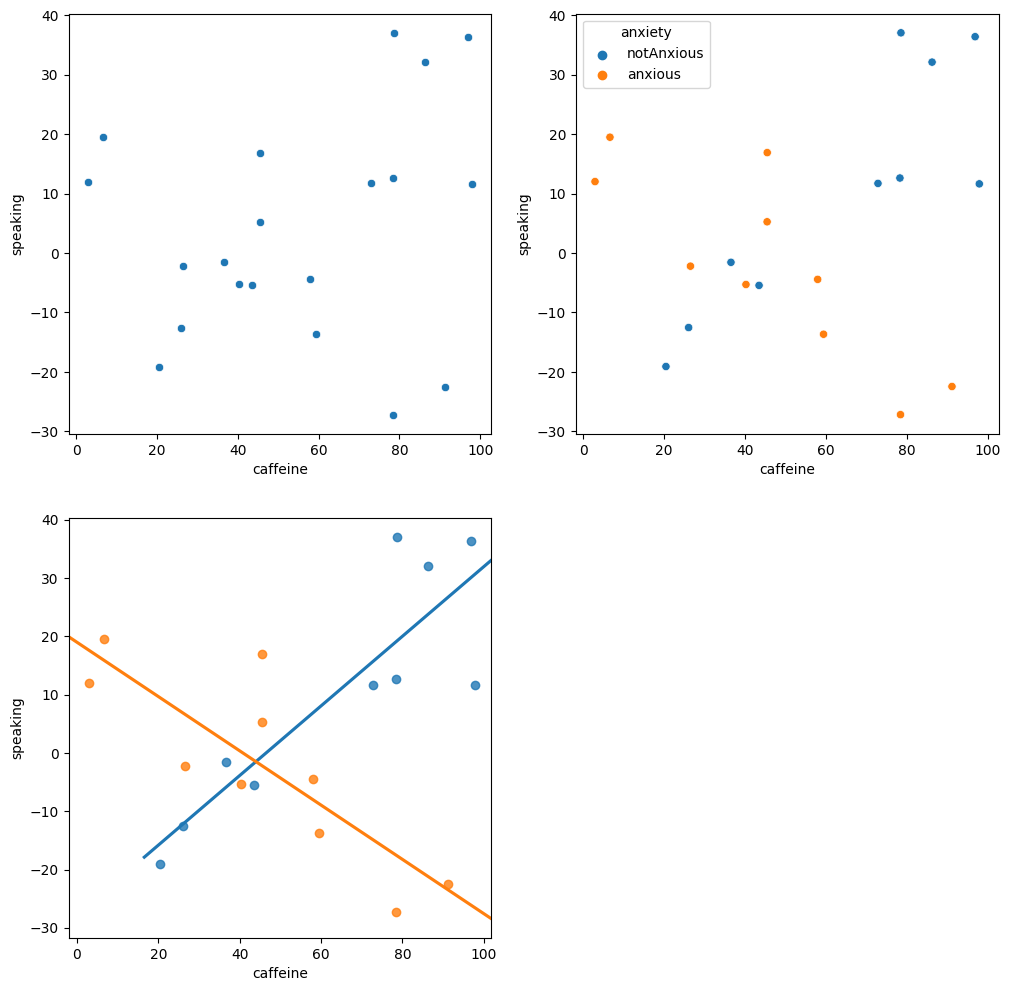

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))

df = pd.DataFrame({'group': [-1, 1] * 10,
                  'caffeine': rng.uniform(size=20) * 100})
df['speaking'] = 0.5 * df.caffeine * -df.group + 20 * df.group + rng.normal(size=20) * 10
df['anxiety'] = ['anxious' if i == 1 else 'notAnxious' for i in df.group]


# perform linear regression with caffeine as independent variable
res_caf = smf.ols(formula='speaking ~ caffeine', data=df).fit()

# compute linear regression adding anxiety to model
res_caf_anx = smf.ols(formula='speaking ~ caffeine + anxiety', data=df).fit()

# compute linear regression including caffeine X anxiety interaction
res_caf_anx_int = smf.ols(formula='speaking ~ caffeine * anxiety', data=df).fit()

sns.scatterplot(data=df, x='caffeine', y='speaking', ax=ax[0][0])

sns.scatterplot(data=df, x='caffeine', y='speaking', hue='anxiety', ax=ax[0][1])

sns.regplot(data=df.query('group == -1'), x='caffeine', y='speaking',  ax=ax[1][0], ci=None, truncate=False)
sns.regplot(data=df.query('group == 1'), x='caffeine', y='speaking',  ax=ax[1][0], ci=None, truncate=False)

ax[1][1].set_visible(False)

## Linear model for caffeine

In [10]:
print(res_caf.summary())

                            OLS Regression Results                            
Dep. Variable:               speaking   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9718
Date:                Tue, 21 Feb 2023   Prob (F-statistic):              0.337
Time:                        06:58:30   Log-Likelihood:                -86.007
No. Observations:                  20   AIC:                             176.0
Df Residuals:                      18   BIC:                             178.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.7625      8.994     -0.418      0.6

## Linear model result for caffeine and anxiety

In [11]:
print(res_caf_anx.summary())

                            OLS Regression Results                            
Dep. Variable:               speaking   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.283
Date:                Tue, 21 Feb 2023   Prob (F-statistic):              0.303
Time:                        06:58:30   Log-Likelihood:                -85.127
No. Observations:                  20   AIC:                             176.3
Df Residuals:                      17   BIC:                             179.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -5.94

## Linear model result for interaction

In [12]:
print(res_caf_anx_int.summary())

                            OLS Regression Results                            
Dep. Variable:               speaking   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     16.99
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           3.14e-05
Time:                        06:58:30   Log-Likelihood:                -72.214
No. Observations:                  20   AIC:                             152.4
Df Residuals:                      16   BIC:                             156.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

## Analysis of variance result

In [13]:
print(sm.stats.anova_lm(res_caf_anx, res_caf_anx_int))

   df_resid          ssr  df_diff      ss_diff          F    Pr(>F)
0      17.0  5828.534062      0.0          NaN        NaN       NaN
1      16.0  1602.468696      1.0  4226.065367  42.195549  0.000007


## Figure 14.5

Text(0.5, 1.0, 'Non-normal data')

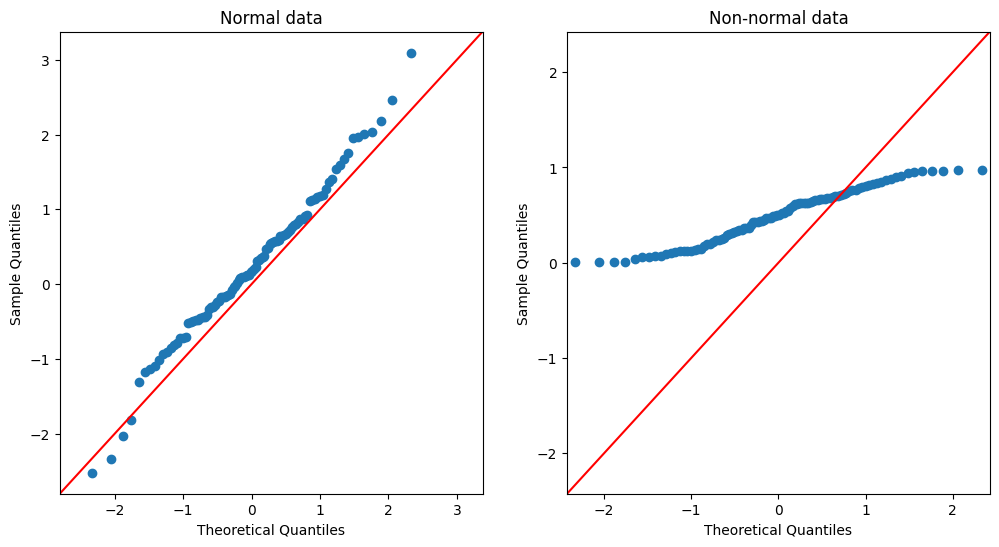

In [14]:
qq_df = pd.DataFrame({'norm': rng.normal(size=100),
                      'unif': rng.uniform(size=100)})

fig, ax = plt.subplots(1, 2, figsize=(12,6))

_ = sm.qqplot(qq_df['norm'], line ='45', ax=ax[0])
ax[0].set_title('Normal data')

_ = sm.qqplot(qq_df['unif'], line ='45', ax=ax[1])
ax[1].set_title('Non-normal data')


## Table 14.2

In [15]:
NHANES_child = NHANES.query('Age < 18')[['Height', 'Weight', 'TVHrsDayChild', 'HHIncomeMid', 'CompHrsDayChild', 'Age']].dropna()

# create function to sample data and compute regression on in-sample and out-of-sample data

def get_sample_predictions(sample_size=250, shuffle = False):
    # generate a sample from NHANES
    orig_sample = NHANES_child.sample(sample_size)

    # if shuffle is turned on, then randomly shuffle the weight variable
    if shuffle:
        orig_sample.Weight = rng.permuted(orig_sample.Weight)

    # compute the regression line for Weight, as a function of several
    # other variables (with all possible interactions between variables)
    heightRegressOrig = smf.ols(
        formula='Weight ~ Height * TVHrsDayChild * CompHrsDayChild * HHIncomeMid * Age',
        data=orig_sample).fit()

    # compute the predictions
    pred_orig = heightRegressOrig.predict(orig_sample)
    

    # create a new sample from the same population
    new_sample = NHANES_child.sample(sample_size)

    # use the model fom the original sample to predict the
    # Weight values for the new sample
    pred_new = heightRegressOrig.predict(new_sample)

    # return r-squared and rmse for original and new data
    return([
        r2_score(pred_orig, orig_sample.Weight),
        r2_score(pred_new, new_sample.Weight),
        np.sqrt(mean_squared_error(pred_orig, orig_sample.Weight)),
        np.sqrt(mean_squared_error(pred_new, new_sample.Weight))])


# implement the function
nruns = 100
sim_results = pd.DataFrame([get_sample_predictions() for i in range(nruns)],
                           columns=['r2_orig', 'r2_new', 'RMSE_orig', 'RMSE_new'])
sim_results_shuffled = pd.DataFrame([get_sample_predictions(shuffle=True) for i in range(nruns)],
                           columns=['r2_orig', 'r2_new', 'RMSE_orig', 'RMSE_new'])

sim_results_combined = pd.DataFrame(sim_results.mean(), columns=['True data'])

sim_results_combined['Shuffled data'] = (sim_results_shuffled.mean())

sim_results_combined

,True data,Shuffled data
r2_orig,0.491621,-1.779596
r2_new,0.470170,-0.927572
RMSE_orig,20.122923,32.517815
RMSE_new,62.272929,28.427277


## Table 14.3

In [16]:
# create a function to run cross-validation
# returns the metrics for the out-of-sample prediction

def compute_cv(df, sampleSize = 250, nfolds = 6):
    kf = KFold(n_splits=nfolds, shuffle=True)
    orig_sample = df.sample(sampleSize)
    fullsample_model = smf.ols(
        formula='Weight ~ Height * TVHrsDayChild * CompHrsDayChild * HHIncomeMid * Age',
        data=orig_sample).fit()
    new_sample = df.sample(sampleSize)
    
    pred = np.zeros(orig_sample.shape[0]) * np.nan
    for train_index, test_index in kf.split(orig_sample):
        train_df = orig_sample.iloc[train_index, :]
        test_df = orig_sample.iloc[test_index, :]
        train_model = smf.ols(
            formula='Weight ~ Height * TVHrsDayChild * CompHrsDayChild * HHIncomeMid * Age',
            data=train_df).fit()
        pred[test_index] = train_model.predict(test_df)

    results = [
        # full original data
        np.sqrt(mean_squared_error(fullsample_model.predict(), orig_sample.Weight)),
        r2_score(fullsample_model.predict(), orig_sample.Weight),
        # new data
        np.sqrt(mean_squared_error(fullsample_model.predict(new_sample), new_sample.Weight)),
        r2_score(fullsample_model.predict(new_sample), new_sample.Weight),
        # CV
        np.sqrt(mean_squared_error(pred, orig_sample.Weight)),
        r2_score(pred, orig_sample.Weight)]
    return(results)

nruns = 1000
sim_results = pd.DataFrame([compute_cv(NHANES_child) for i in range(nruns)],
                           columns=['RMSE_insample', 'R2_insample',
                                    'RMSE_newdata', 'R2_newdata',
                                   'RMSE_CV', 'R2_CV'])
sim_results.mean()

RMSE_insample     19.952566
R2_insample        0.500228
RMSE_newdata      53.152403
R2_newdata         0.482769
RMSE_CV          279.376660
R2_CV              0.455041
dtype: float64

## Table 14.4

In [17]:

df = pd.DataFrame({'studyTime': np.array([2, 3, 5, 6, 6, 8, 10, 12]) / 3,
                   'priorClass': [0, 1, 1, 0, 1, 0, 1, 0]})
df['grade'] = df.values.dot(betas) + rng.normal(size=8, loc = 70, scale = 5)


df.values

array([[  0.66666667,   0.        ,  81.40234345],
       [  1.        ,   1.        ,  78.49643294],
       [  1.66666667,   1.        ,  77.8962827 ],
       [  2.        ,   0.        ,  79.66479948],
       [  2.        ,   1.        ,  86.82553731],
       [  2.66666667,   0.        ,  88.18580407],
       [  3.33333333,   1.        , 100.96621238],
       [  4.        ,   0.        ,  99.59806513]])

## Table 14.5

In [18]:
# compute beta estimates using linear algebra

#create Y variable 8 x 1 matrix
Y = df.grade

#create X variable 8 x 2 matrix
X = np.zeros((df.shape[0], 2))

#assign studyTime values to first column in X matrix
X[:, 1] = df.studyTime.values - df.studyTime.values.mean()

#assign constant of 1 to second column in X matrix
X[:, 0] = 1

# compute inverse of X using ginv()
# %*% is the R matrix multiplication operator

beta_hat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y.values) #multiple the inverse of X by Y

beta_df = pd.DataFrame({'True': [grade_intercept, betas[0]],
                        'Estimated': beta_hat}, index=['intercept', 'grade'])

beta_df

,True,Estimated
intercept,70,86.629435
grade,6,7.211706


In [19]:
# confirm results same as statsmodels

mod2 = sm.OLS(Y, X)
res2 = mod2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                  grade   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     20.99
Date:                Tue, 21 Feb 2023   Prob (F-statistic):            0.00376
Time:                        07:00:17   Log-Likelihood:                -22.569
No. Observations:                   8   AIC:                             49.14
Df Residuals:                       6   BIC:                             49.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         86.6294      1.659     52.213      0.0

/home/poldrack/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
